# SNUH-NVIDIA MONAI Bootcamp - Getting Started with MONAI

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>

Welcome to the MONAI bootcamp! This notebook will introduce you to an end-to-end workin in MONAI using both a standard PyTorch loop and using Ignite, followed by a hands-on implementing your own segmentation using everything you've learned so far.

#### Required Packages 

Execute the following cell to install MONAI the first time a colab notebook is run:

In [ ]:
#!pip install -qU "monai-weekly[all]"

### Check GPU Support

 Running

`!nvidia-smi`

in a cell will verify this has worked and show you what kind of hardware you have access to.

In [1]:
!nvidia-smi

Mon Aug 21 04:53:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0    52W / 400W |     39MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                   On |
| N/A   

# Getting Started with MONAI

MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging, part of PyTorch Ecosystem.

Its ambitions are:

developing a community of academic, industrial and clinical researchers collaborating on a common foundation;
creating state-of-the-art, end-to-end training workflows for healthcare imaging;
providing researchers with the optimized and standardized way to create and evaluate deep learning models.
MONAI aims at supporting deep learning in medical image analysis at multiple granularities. This figure shows a typical example of the end-to-end workflow in medical deep learning area:

![monai pipeline](https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/end_to_end.png)


# What's the Need?
Biomedical applications have specific requirements
Image modalities (MR, CT, US, etc.) require specific data processing
Data formats (DICOM, NIfTI, etc.) are specific to medical applications and require special support
Certain network architectures are designed for, or are highly suitable for, biomedical applications
Data transforms specific to biomedical applications, and to image modalities, are very useful when pre-processing data, augmenting data during training, and post-processing
Reproducible science requires reproducible experiments which in turn rely on software accessible to other scientists, even if just as a common baseline
A community-driven library to provide solutions to these requirements reduces duplication/re-implementation
Baseline implementations of common networks, and implementations of networks specific to certain papers, provides a basis for comparison between other's networks and results
How Does MONAI Address This Need?
MONAI provides a framework of deep learning facilities and infrastructure to meet these needs in a flexible Pytorch-compatible way:

Data loading and handling library for biomedical file types
Large set of data transforms to process, regularize, and augment image date before, during, and after training
Library of general-purpose network, metric, and loss function definitions implementing common architectures
Set of ready-made components for training and inference to utilize computing infrastructure efficiently
MONAI contributes to reproducibilty by making the training and distribution of experiments easier:

Common underlying framework betweeen different users' implementations aids in comparison and interoperability
Users can pick and choose components and existing networks then contribute new code to make their results available to others
Reference implementations of networks from papers provides baselines for replication studies and comparisons

# MONAI architecture

The design principle of MONAI is to provide flexible and light APIs for users with varying expertise. All the core components are independent modules, which can be easily integrated into any existing PyTorch programs. Users can leverage the workflows in MONAI to quickly set up a robust training or evaluation program for research experiments. Rich examples and demos are provided to demonstrate the key features. Researchers contribute implementations based on the state-of-the-art for the latest research challenges, including COVID-19 image analysis, Model Parallel, etc.


![monai architecture](https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/arch_modules_v0.4.png)

# MONAI Design Philosophy

Key principles:

- MONAI looks like PyTorch, uses/extends PyTorch types and adheres to it's general design philosophy
- MONAI is additive on top of PyTorch, providing extensions or wrappers
- MONAI is opt-in and incremental, no need to rewrite entire models to integrate existing code
- MONAI is collaborative, providing adapters and loosely coupled components to ease integration with third party code
- MONAI is PyTorch ecosystem friendly, and part of the official ecosystem!

# MONAI Transforms
To help you understand more about MONAI transforms, this guide will help you answer five key questions:

 1. What transforms are available to help create a data pipeline for training?
 2. What are array transforms?
 3. What is required to write a custom transform?
 4. What are dictionary transforms?
 5. How do I create a basic MONAI dataset with transforms?

Let's get started by importing our dependecies. We're going to load everything that we'll need for the remainder of the notebook here. You'll see a lot of import statements, but we'll make sure to go over each of them throughout the rest of the notebook.

In [1]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (Transform, MapTransform, Randomizable, EnsureChannelFirst, EnsureChannelFirstd,
Compose, LoadImage, LoadImaged, Lambda, Lambdad, RandSpatialCrop, RandSpatialCropd, RandGaussianNoise,
RandGaussianNoised, Orientation, Rotate, MapTransform)

print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0


Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




# 1. What transforms are available to help create a data pipeline for training?

## Medical image data I/O, processing and augmentation

Medical images require highly specialized methods for I/O, preprocessing, and augmentation. Medical images are often in specialized formats with rich meta-information, and the data volumes are often high-dimensional. These require carefully designed manipulation procedures. The medical imaging focus of MONAI is enabled by powerful and flexible image transformations that facilitate user-friendly, reproducible, optimized medical data pre-processing pipelines.

![seg](https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/medical_transforms.png)

## Transforms support both Dictionary and Array format data

The widely used computer vision packages (such as torchvision) focus on spatially 2D array image processing. MONAI provides more domain-specific transformations for both spatially 2D and 3D and retains the flexible transformation “compose” feature.

As medical image preprocessing often requires additional fine-grained system parameters, MONAI provides transforms for input data encapsulated in python dictionaries. Users can specify the keys corresponding to the expected data fields and system parameters to compose complex transformations.

There is a rich set of transforms in six categories: Crop & Pad, Intensity, IO, Post-processing, Spatial, and Utilities. For more details, please visit all the transforms in MONAI.

## Medical specific transforms

MONAI aims at providing a comprehensive medical image specific transformations. These currently include, for example:

 - LoadImage: Load medical specific formats file from provided path
 - Spacing: Resample input image into the specified pixdim
 - Orientation: Change the image’s orientation into the specified axcodes
 - RandGaussianNoise: Perturb image intensities by adding statistical noises
 - NormalizeIntensity: Intensity Normalization based on mean and standard deviation
 - Affine: Transform image based on the affine parameters
 - Rand2DElastic: Random elastic deformation and affine in 2D
 - Rand3DElastic: Random elastic deformation and affine in 3D


#### Create syntheric Toy Data and Temp Directory for Examples 
We'll create a temporary directory and populate it with a few example Nifti file-format images containing a random assortment of spheres. We're also creating a matching segmentation pair that will be used later in the notebook.

In [2]:
%%time

fn_keys = ("img", "seg")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(256, 256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

CPU times: user 10.2 s, sys: 1.96 s, total: 12.2 s
Wall time: 12.2 s


## 2. What are array transforms?

Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it.

Transforms are composed with Compose to create a sequence of operations. Compose itself being a transform we can also call it directly. The type of img here is numpy.ndarray so to convert to a Pytorch tensor as part of a training data pipeline we'd have ToTensor as the last transform in our sequence:

#### Array Transforms
Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it.

In [3]:
trans = Compose([LoadImage(image_only=True), EnsureChannelFirst()])
img = trans(filenames[0]["img"])
print(type(img), img.shape, img.get_device())

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 256, 256, 256]) -1


#### Dictionary Transforms
So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed:

- To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform
- These can be applied to named values in an input dictionary while leaving unnamed values untouched
  - for example adding noise to an image while leaving the associated label image untouched.

#### Dictionary Transforms
Earlier in the notebook we imported the dictionary equivalent transforms which have a *`'d'`* appended to their names:

- We'll use those transforms in this section
- The keys argument in LoadNiftid is used to state which keys contain paths to Nifti files
 - All other values in the input dictionary will be retained
 - With this set we can look at the keys returned when calling the transform:

In [4]:
trans = LoadImaged(keys=fn_keys)
data = trans(filenames[0])
print(list(data.keys()))

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


## 3. How do I create a custom transform?

We can define our own custom transform operation in a number of ways. 
If a simple callable is used as an operator, *`Lambda`* can be used to wrap it as a transform. 
We define in this example a transform to sum the image in the 1st (width) dimension to produce a 2D image:

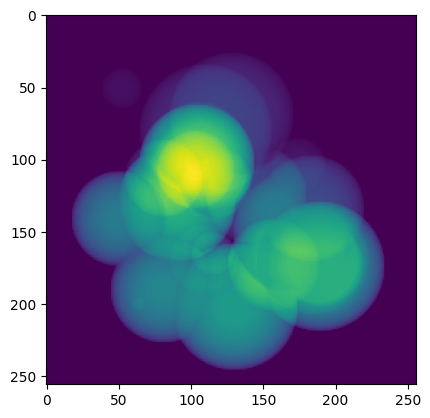

In [5]:
def sum_width(img):
    return img.sum(1)

trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), Lambda(sum_width)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects. Let's define a class to sum in a chosen dimension, and use it to sum in the 2nd (height) dimension:

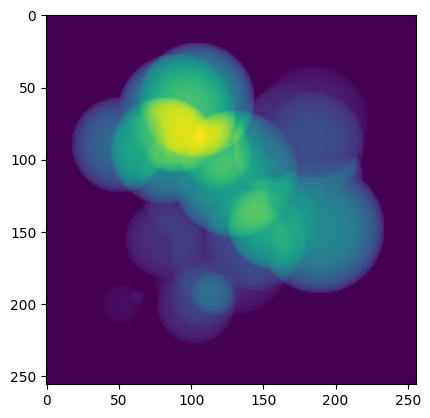

In [6]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), SumDimension(2)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

All of these example transforms so far have been deterministic, to define transforms which perform some stochastic operation on input data we want to also inherit from `Randomizable`. This class is used to randomize variables but also distinguish from deterministic transforms. We'll see why this is important later in caching data loaders.

In this class we have a `numpy.random.RandomState` object to provide stochastic values. This can be replaced using `Randomizable.set_random_state()` to control the randomization process. The `randomize()` method is responsible for determining if the random operation is to be performed based on the `prob` probability member, then creates the random noise array if so. This functionality is in this method so that it can be called by `Compose` or other external controllers.

For now lets define a simple transform to add noise.

<b>Run this cell a few times to see the random transform being applied 50% of the time.</b>

Max Noise Value: 0.9999998807907104, Min Noise Value: 0.0


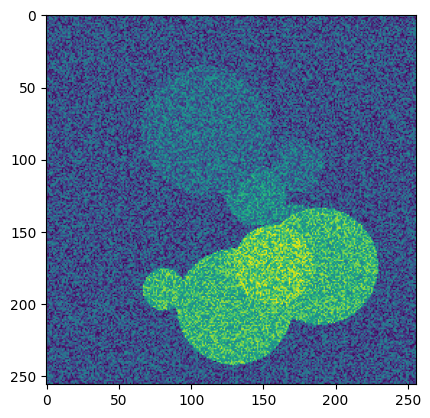

In [12]:
import torch
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = None  

    def randomize(self, data: torch.Tensor) -> None:
        # Always create a tensor for _noise, even if it's just zeros
        noise_array = torch.zeros(*data.shape)

        if np.random.random() < self.prob:
            noise_array = torch.rand(*data.shape) * self.max_add
            print(f"Max Noise Value: {torch.max(noise_array)}, Min Noise Value: {torch.min(noise_array)}")

        self._noise = noise_array.type(data.dtype)

        
    def add_noise(self, img: torch.Tensor) -> torch.Tensor:
        return img + self._noise.to(img.device)

    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        self.randomize(img)
        return self.add_noise(img)

trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), RandAdditiveNoise()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, 128])

## 4. What are dictionary transforms?

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed. To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform. These can be applied to named values in an input dictionary while leaving unnamed values untouched, for example adding noise to an image while leaving the associated label image untouched.

Earlier in the notebook we imported the dictionary equivalent transforms which have a d appended to their names, we'll use those transforms in this section. The `keys` argument in `LoadNiftid` is used to state which keys contain paths to Nifti files, all other values in the input dictionary will be retained. With this set we can look at the keys returned when calling the transform:

In [8]:
trans = LoadImaged(keys=fn_keys)
data = trans(filenames[0])
print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


`Lambdad` applies the given callable to each array named by `keys` separately. We can use this to define transforms operating on different named values in the dictionary at different points in the sequence:

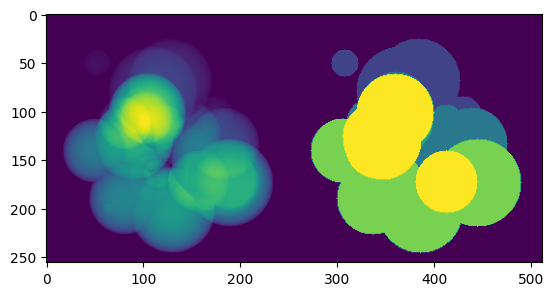

In [9]:
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

trans = Compose(
    [LoadImaged(fn_keys), EnsureChannelFirstd(fn_keys), Lambdad(("img",), sum_width), Lambdad(("seg",), max_width)]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), np.squeeze(seg[0]))))

The above applies one operation to one member of the dictionary and different operation to another. A reasonable re-implementation of this in one transform would require retaining the names of which members to apply which transform to and applying the operations in one method. Adapting array-based transforms to operate over dictionaries is relatively straight-forward.

<b>Run this cell a few times to see the random transform being applied 50% of the time.</b>

Max Noise Value: 0.9999999403953552, Min Noise Value: 0.0


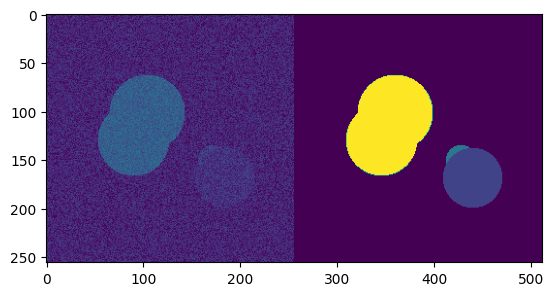

In [13]:
class RandAdditiveNoised(Randomizable, MapTransform):
    def __init__(
        self, keys: KeysCollection, prob: float = 0.5, max_add: float = 1.0
    ) -> None:
        super(Randomizable, self).__init__(keys)
        self.transform = RandAdditiveNoise(prob, max_add)

    def set_random_state(
        self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None
    ) -> "RandAdditiveNoised":
        self.transform.set_random_state(seed, state)
        super().set_random_state(seed, state)
        return self

    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize(data)

    def __call__(
        self, data: Mapping[Hashable, np.ndarray]
    ) -> Mapping[Hashable, np.ndarray]:
        self.randomize(data[monai.utils.first(self.keys)])

        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.add_noise(d[key])
        return d

trans = Compose([LoadImaged(fn_keys), EnsureChannelFirstd(fn_keys), RandAdditiveNoised(("img",))])
img = trans(filenames[0])

# We're adding random noise to the image, not the segmentation
plt.imshow(np.hstack([img["img"][0, 50], img["seg"][0, 50]])) 

Method overrides are provided to delegate behaviour to an internal `RandAdditiveNoise` instance:

 - `set_random_state` sets the state of the delegate and the current object
 - `randomize` delegates the randomization to the `RandAdditiveNoise` instance
 - `__call__` causes the delegate to randomize then applies the transform to each named member of the dictionary. The delegate transform is randomized only once, this ensures the same random field is added to each named member of the dictionary, a slightly different implementation adding a per-key random field would be needed if this were the desired behaviour.

 ## 5. How do I create a basic MONAI dataset with transforms?
 
Now that we've taken a look at transform, let's take a look at datasets. With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image Nifti files only.

`Dataset` inherits from the Pytorch class of that name and adds only the ability to apply the given transform to selected items. If you're familiar with the class from Pytorch this will work the same way.

In [14]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadImage(image_only=True), EnsureChannelFirst()])
ds = Dataset(images, transform)
img_tensor = ds[0]
print(img_tensor.shape, img_tensor.get_device())

torch.Size([1, 256, 256, 256]) -1


#### ArrayDataset 
MONAI provides the `ArrayDataset` for supervised training applications specifically. It can accept data arrays for images separate from those for segmentations or labels with their own separate transforms. Here we will again separate out the image and segmentation filenames to demonstrate this usage:

In [15]:
from typing import Dict  # Import Dict from the typing module
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = None

    def randomize(self, data: torch.Tensor) -> None:
        self._noise = None

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = torch.tensor(noise_array * self.max_add, dtype=data.dtype).to(data.device)

    def add_noise(self, img: torch.Tensor) -> torch.Tensor:
        return img + self._noise if self._noise is not None else img

    def __call__(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        self.randomize(data['img'])
        data['img'] = self.add_noise(data['img'])
        return data

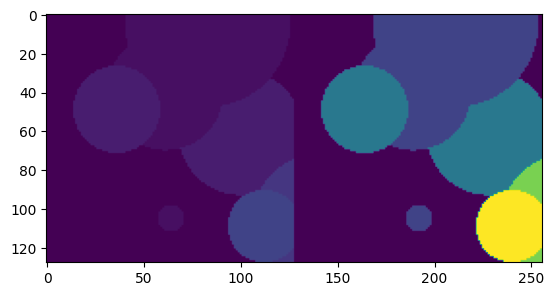

In [16]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        RandGaussianNoise(.5, 1, 1),
    ]
)
seg_transform = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), RandSpatialCrop((128, 128, 128), random_size=False)]
)

ds = ArrayDataset(images, img_transform, segs, seg_transform)
im, seg = ds[0]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

Instead of returning a single image, accessing a member of the dataset produces a pair containing the image and segmentation after being pass through their respective transforms. One important aspect of this class is that the random state of each transform (`Compose` in this case) is set to that of the dataset before being applied. This ensures the same random operations are applied to each output, which is why the `RandSpatialCrop` operation chooses the same crop window for the image as well as the segmentation. By having separate transforms one can apply operations to images and not to segmentations (or vice versa), being careful that these unshared operations come after the shared ones.

Alternatively, `Dataset` can be used with dictionary-based transforms to construct a result mapping. For training applications beyond simple input/ground-truth pairs like the above this would be more suitable:

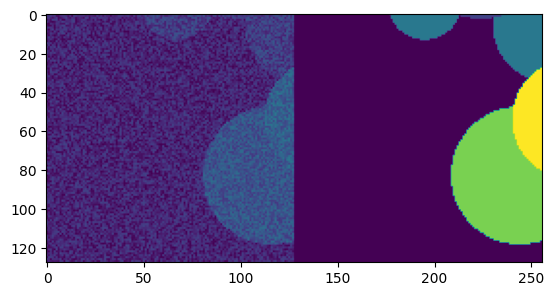

In [17]:
trans = Compose([LoadImaged(fn_keys), EnsureChannelFirstd(fn_keys), RandAdditiveNoised(("img",)), 
                 RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False) ])

ds = Dataset(filenames, trans)
item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

With the dataset defined, we can now create the dataloader to create data batches. This inherits directly from Pytorch's `DataLoader` class with a few changes to the default constructor arguments. MONAI functionality should be compatible with the PyTorch `DataLoader`, but it was subclasses to include additional functionality that we consider key and which cannot be realized with the standard `DataLoader` class.

The `DataLoader` will use five worker processes to load the actual data. MONAI provides a number of `Dataset` subclasses to improve the efficiency of this process. These and other features will be covered in subsequent labs.

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([4, 1, 128, 128, 128])


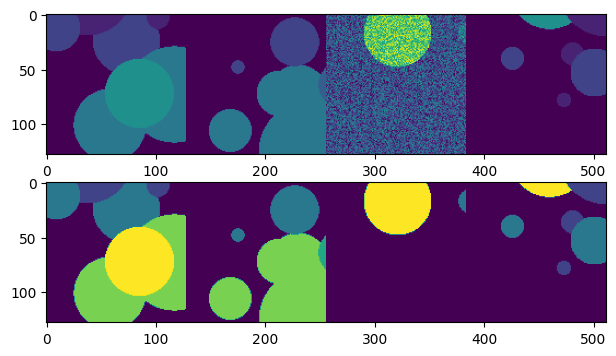

In [18]:
loader = DataLoader(ds, batch_size=4, num_workers=0)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

#### Example of Real dataset 

##### Download dataset
Downloads and extracts the dataset. The dataset comes from https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/.

The dataset used in this competition is provided for research purposes only. Commercial uses are not allowed.

K. Sirinukunwattana, J. P. W. Pluim, H. Chen, X Qi, P. Heng, Y. Guo, L. Wang, B. J. Matuszewski, E. Bruni, U. Sanchez, A. Böhm, O. Ronneberger, B. Ben Cheikh, D. Racoceanu, P. Kainz, M. Pfeiffer, M. Urschler, D. R. J. Snead, N. M. Rajpoot, "Gland Segmentation in Colon Histology Images: The GlaS Challenge Contest" http://arxiv.org/abs/1603.00275

K. Sirinukunwattana, D.R.J. Snead, N.M. Rajpoot, "A Stochastic Polygons Model for Glandular Structures in Colon Histology Images," in IEEE Transactions on Medical Imaging, 2015 doi: 10.1109/TMI.2015.2433900

In [22]:
import os 
import PIL
import numpy as np
import matplotlib.pyplot as plt
from monai.apps import download_and_extract

root_dir="./dataset"
resource = (
    "https://warwick.ac.uk/fac/sci/dcs/research/tia/"
    + "glascontest/download/warwick_qu_dataset_released_2016_07_08.zip"
)
md5 = None

compressed_file = os.path.join(root_dir , "warwick_qu_dataset_released_2016_07_08.zip")
data_dir = os.path.join(root_dir, "Warwick QU Dataset (Released 2016_07_08)")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [23]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"

In [24]:
img_name = os.path.join(data_dir, "train_22.bmp")
seg_name = os.path.join(data_dir, "train_22_anno.bmp")
im = np.array(PIL.Image.open(img_name))
seg = np.array(PIL.Image.open(seg_name))

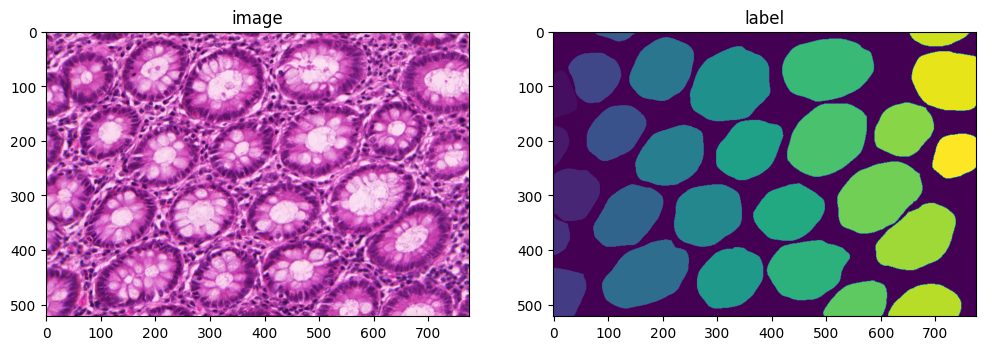

(522, 775, 3) (522, 775)


In [25]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(seg)
plt.show()
print(im.shape, seg.shape)

##### Affine transform

In [26]:

from monai.transforms import Affine

# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

# create an Affine transform
affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode="zeros",
    device=device,
)
# convert both image and segmentation using different interpolation mode
new_img, _ = affine(im_data, (300, 400), mode="bilinear")
new_seg, _ = affine(seg_data, (300, 400), mode="nearest")
print(new_img.shape, new_seg.shape)

torch.Size([3, 300, 400]) torch.Size([1, 300, 400])


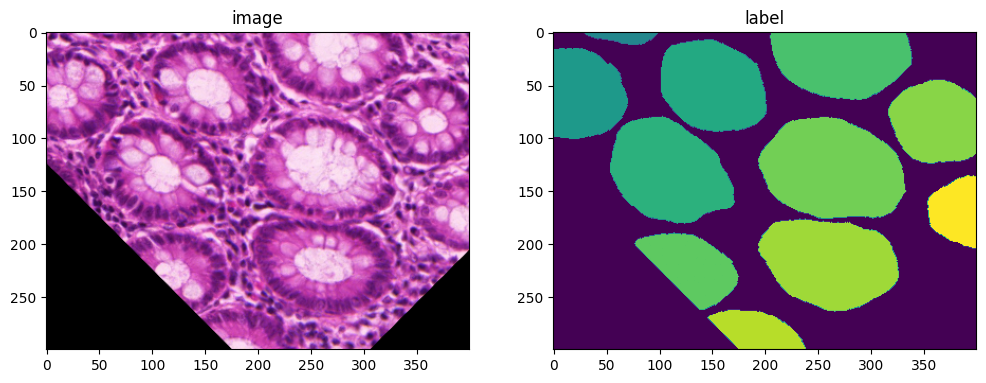

In [27]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

##### Elastic deformation


In [28]:
from monai.transforms import  Rand2DElastic

# create an elsatic deformation transform
deform = Rand2DElastic(
    prob=1.0,
    spacing=(30, 30),
    magnitude_range=(5, 6),
    rotate_range=(np.pi / 4,),
    scale_range=(0.2, 0.2),
    translate_range=(100, 100),
    padding_mode="zeros",
    device=device,
)
# transform both image and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode="bilinear")
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode="nearest")
print(new_img.shape, new_seg.shape)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


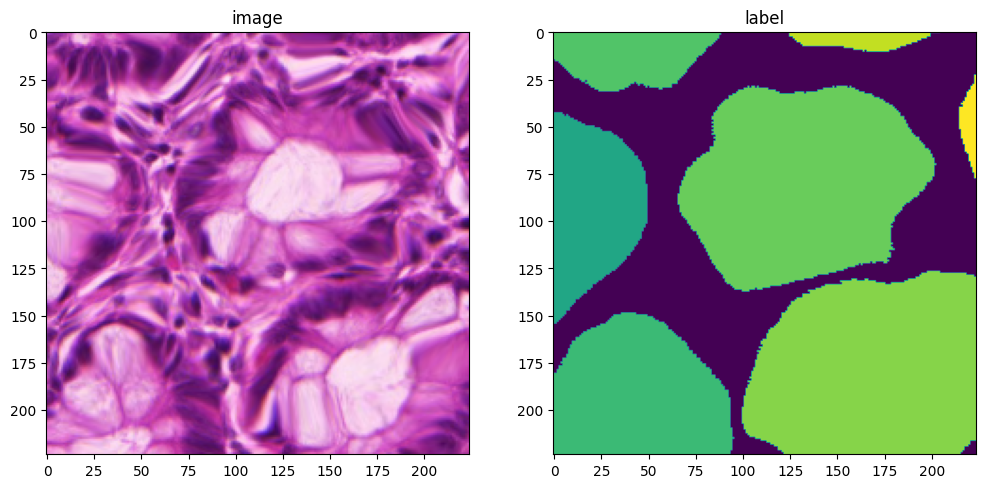

In [29]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

## Assignment 1  GibbsNoise blur

apply Gibsnoise with `alpha=0.93` in default, alpha=0.5 .

In [30]:

from monai.transforms import GibbsNoise

# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

## TODO 
apply_gibbsnoise = GibbsNoise(  ) ## TODO 
## TODO 

# convert both image and segmentation using different interpolation mode
new_img = apply_gibbsnoise(im_data  )

print(new_img.shape, seg.shape)

torch.Size([3, 522, 775]) (522, 775)


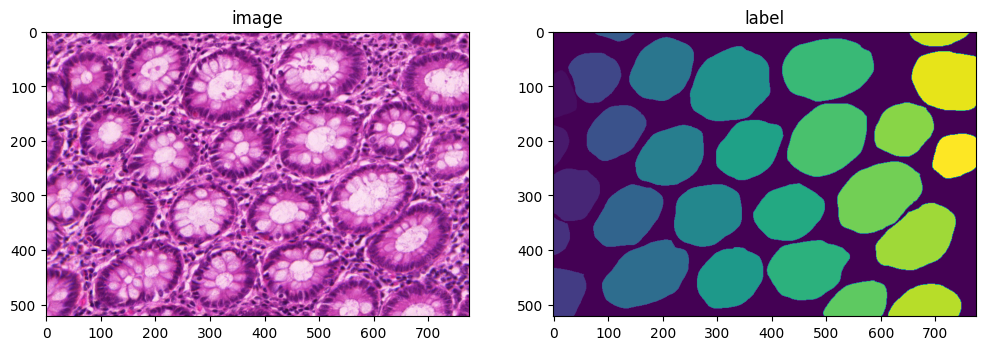

In [31]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(seg)
plt.show()

###  What is a MONAI Dataset and how does dataset caching work?

Users often need to train the model with many (potentially thousands of) epochs over the data to achieve the desired model quality:

- A native PyTorch implementation may repeatedly load data and run the same preprocessing steps for every epoch during training
- Can be time-consuming and unnecessary, especially when the medical image volumes are large
- By utilizing Dataset Caching, you can reduce the amount of time your system takes to load this data and preprocess it
- Reducing your overall training time.
We will demonstrate two of the Dataset subclasses here but there are additional useful specialised Datasets

##### What is a MONAI Dataset?
A MONAI Dataset is a generic dataset with a len property, getitem property, and an optional callable data transform when fetching a data sample.

We'll start by initializing some generic data, calling the Dataset class with the generic data, and specifying None for our transforms.



In [32]:
items = [{"data": 4}, 
         {"data": 9}, 
         {"data": 3}, 
         {"data": 7}, 
         {"data": 1},
         {"data": 2},
         {"data": 5}]
dataset = monai.data.Dataset(items, transform=None)

print(f"Length of dataset is {len(dataset)}")
for item in dataset:
    print(item)

Length of dataset is 7
{'data': 4}
{'data': 9}
{'data': 3}
{'data': 7}
{'data': 1}
{'data': 2}
{'data': 5}


#### Dataset compatibility with PyTorch DataLoader
MONAI datasets can be used with vanilla PyTorch DataLoader:

As mentioned, MONAI's DataLoader has additional useful functionality

In [33]:
for item in torch.utils.data.DataLoader(dataset, batch_size=2):
    print(item)

{'data': tensor([4, 9])}
{'data': tensor([3, 7])}
{'data': tensor([1, 2])}
{'data': tensor([5])}


#### What is Dataset Caching and how do I use it?
MONAI provides multi-thread versions of CacheDataset and LMDBDataset to accelerate transformation pipelines during training:

- put deterministic transforms first, and random transforms after
- the output of the deterministic transforms is always the same, so only compute once!
- random transforms produce different outputs each time they are used so must be computed every time
  - can provide up to 10x training speedup in the Datasets experiment.
    
![](https://raw.githubusercontent.com/Project-MONAI/monai-bootcamp/459d7cac551422e8c5560ec6b8689ae234eab427/MONAICore/cache_dataset.png    )

To demonstrate the benefit dataset caching, we're going to construct a dataset with a slow transform:

To do that, we're going to call the sleep function during each of the `__call__` functions.

In [34]:
import time  # Import the time module
from monai.transforms import MapTransform
from monai.data import Dataset

class SlowSquare(MapTransform):
    def __init__(self, keys):
        MapTransform.__init__(self, keys)
        print(f"keys to square it: {self.keys}")

    def __call__(self, x):
        time.sleep(1.0)
        output = {key: x[key] ** 2 for key in self.keys}
        return output

square_dataset = Dataset(items, transform=SlowSquare(keys="data"))

keys to square it: ('data',)


In [35]:
%time for item in square_dataset: print(item)

{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 2.09 ms, sys: 3.29 ms, total: 5.39 ms
Wall time: 7.01 s


Every time we run this loop it takes roughly 7 seconds to go through all of the items:

- 12 extra minutes of load time for 100 epochs
- We can improve this time by utilizing caching.

#### Cache Dataset
When using [CacheDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#cachedataset) the caching is done when the object is initialized for the first time, so the initialization is slower than a regular dataset:

- By caching the results of non-random preprocessing transforms, it accelerates the training data pipeline
- If the requested data is not in the cache, all transforms will run normally.

In [36]:
from monai.data import (Dataset, ArrayDataset, create_test_image_3d, DataLoader, DataLoader, 
CacheDataset, PersistentDataset, SmartCacheDataset)

In [37]:
square_cached = CacheDataset(items, transform=SlowSquare(keys='data'))

keys to square it: ('data',)


Loading dataset: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


However, repeatedly fetching the items from an initialized CacheDataset is fast.

In [38]:
%timeit list(square_cached)

11.5 µs ± 31.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### Persistent Caching
[PersistentDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#persistentdataset) allows for persistent storage of pre-computed values to efficiently manage larger than memory dictionary format data:

Again, the non-random transform components are computed when first used
Stored in the cache_dir for rapid retrieval on subsequent uses

In [39]:
square_persist = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")

keys to square it: ('data',)


In [40]:
%time for item in square_persist: print(item)

{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 11.7 ms, sys: 16.4 ms, total: 28.1 ms
Wall time: 7.03 s


In [41]:
!ls my_cache

57d3e1f66415b9a6a36a90dd89c708c3.pt  acdbabea1a1facbf07dbe5010a951af9.pt
5ec8e24ba3963d83f2f6c81744796545.pt  ca0b3885ae71075716d5bd863961a8bc.pt
6c81bd5aa312ecd4ba9a5e0340e06a55.pt  f263a1a8f1344ac65b574f0bf30813af.pt
71177f0b196d6c5f84f26579bf19caae.pt


When calling out to the dataset on the following epochs, it will not call the slow transform but used the cached data.

In [42]:
%timeit list(square_persist)

2.44 ms ± 7.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Fresh dataset instances can make use of the caching data:

In [43]:
square_persist_1 = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")
%timeit list(square_persist_1)

keys to square it: ('data',)
2.45 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Caching in action
There's also a SmartCacheDataset to hide the transforms latency with less memory consumption.
The dataset tutorial notebook has a working example and a comparison of different caching mechanism in MONAI: https://github.com/Project-MONAI/tutorials/blob/master/acceleration/dataset_type_performance.ipynb

![cache_speed](https://raw.githubusercontent.com/Project-MONAI/monai-bootcamp/459d7cac551422e8c5560ec6b8689ae234eab427/MONAICore/datasets_speed.png)

#### common datasets  provided by MONAI
To quickly get started with popular training data in the medical domain, MONAI provides several data-specific Datasets:

- MedNISTDataset, DecathlonDataset, etc.
- Provides easy downloading from our AWS storage, extraction of data files and supports generation of training/evaluation items with transforms

##### Decathlon Dataset
The [DecathlonDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#decathlon-datalist) function leverages the features described throughout this notebook. These datasets are an extension of CacheDataset covered above.

In [44]:
dataset = monai.apps.DecathlonDataset(root_dir="./dataset", task="Task09_Spleen", section="training", download=True)

2023-08-23 10:09:53,754 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-08-23 10:09:53,756 - INFO - File exists: dataset/Task09_Spleen.tar, skipped downloading.
2023-08-23 10:09:53,756 - INFO - Writing into directory: dataset.


Loading dataset: 100%|██████████| 33/33 [03:03<00:00,  5.57s/it]


In [45]:
print(dataset.get_properties("numTraining"))
print(dataset.get_properties("description"))
print(dataset[0]['image'].shape)
print(dataset[0]['label'].shape)

{'numTraining': 41}
{'description': 'Spleen Segmentation'}
torch.Size([512, 512, 55])
torch.Size([512, 512, 55])


#### Create DeccathlonDataset for training

`DecathlonDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior:

- root_dir: user's local directory for caching and loading the MSD datasets.
- task: which task to download and execute: one of list ("Task01_BrainTumour", "Task02_Heart", "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas", "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon").
- section: expected data section, can be: training, validation or test.
- transform: transforms to execute operations on input data. the default transform is composed by LoadImaged and AddChanneld, which can load data into numpy array with [C, H, W, D] shape.
- download: whether to download and extract the Decathlon from resource link, default is False. if expected file already exists, skip downloading even set it to True. user can manually copy tar file or dataset folder to the root directory.
- seed: random seed to randomly split training, validation and test datasets, defaut is 0.
- val_frac: percentage of of validation fraction from the training section, default is 0.2. Decathlon data only contains training section with labels and test section without labels, so randomly select fraction from the training section as the validation section.
- cache_num: number of items to be cached. Default is sys.maxsize. will take the minimum of (cache_num, data_length x cache_rate, data_length).
- cache_rate: percentage of cached data in total, default is 1.0 (cache all). will take the minimum of (cache_num, data_length x cache_rate, data_length).
- num_workers: the number of worker threads to use. if 0 a single thread will be used. Default is 0.

Note that the "tar files" are cached after a first time downloading. the `self.__getitem__()` API generates 1 `{"image": XXX, "label": XXX}` dict according to the specified index within the self.`__len__()`.


In [46]:
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscreted,
    Compose,
    LoadImaged,
    Orientationd,
    Randomizable,
    Resized,
    ScaleIntensityd,
    Spacingd,
    EnsureTyped,
)

In [47]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityd(keys="image"),
        Resized(keys=["image", "label"], spatial_size=(32, 64, 32), mode=("trilinear", "nearest")),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [48]:
train_ds = DecathlonDataset(
    root_dir='./dataset',
    task="Task09_Spleen",
    transform=transform,
    section="training",
    download=True,
)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

NameError: name 'DecathlonDataset' is not defined

#### Pick images from DecathlonDataset to visualize and check

In [ ]:
plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(train_ds[i * 4]["image"][0, :, :, 30].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

# Summary
We've covered MONAI Transforms. Some key highlights are:

There is a long list of medical specific transforms available in MONAI
There are array and dictionary versions of transforms.
You can create a simple callable lambda function or create a class based on transform to create your own custom tranform
You can create a MONAI dataset and directly pass a compose tranform chain to it

# Assignment 1

Now you get to practice creating a transform of your own and integrating it into a compose array.

Create a transform which selects a patch from an input image of a given size and randomly chooses to transpose this data along randomly chosen axes. For example, this could produce an image where a patch in the center has been flipped in the horizontal direction while the rest of the image is left unchanged.

Assumptions:

 - Implement this as an array randomized transform
 - Use a default probability ratio of 40% chance to crop
 - Use one of the test 3D images from above to validate
 - Default crop size is 150 but allow it to be variable
 - Don't worry about edge cases

Below is the initial class definition you'll need to implement. We also include a compose chain and image visualization call that should work once your function is fully implemented.

In [ ]:
class RandFlipRect(Randomizable, Transform):
    """
    Define a transform to randomly transpose a patch of the input image along randomly chosen spatial dimensions. This 
    uses arguments `prob` for the probability the transform is applied, and `size` giving the size of the cube to flip.
    """
    def __init__(self, prob: float = 0.4, size: int = 100) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.size = size
        
    def __call__(self, img: np.ndarray) -> np.ndarray:
        pass # TODO replace this with your code
    
trans = Compose([LoadImage(image_only=True), AddChannel(), RandFlipRect()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, img.shape[1]//2])

## solution

In [ ]:
#@title solution for RandFlipRect
class RandFlipRect(Randomizable, Transform):
    """
    Define a transform to randomly transpose a patch of the input image along randomly chosen spatial dimensions. This 
    uses arguments `prob` for the probability the transform is applied, and `size` giving the size of the cube to flip.
    """
    def __init__(self, prob: float = 0.4, size: int = 100) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.size = size

    def random_flip(self, data: np.ndarray) -> None:
        if self.R.random() < self.prob:
            height = data.shape[1]
            width = data.shape[2]
            depth = data.shape[3]
            
            x = self.R.randint(0, height - self.size)
            y = self.R.randint(0, width - self.size)
            z = self.R.randint(0, depth - self.size)
            patch = data[..., x: x + self.size , y: y + self.size, z: z + self.size]
            
            if self.R.random() < 0.333:
                patch=patch[...,::-1,:,:]
                
            if self.R.random() < 0.333:
                patch=patch[...,::-1,:]
                
            if self.R.random() < 0.333:
                patch=patch[...,::-1]
                
            data[..., x: x + self.size , y: y + self.size, z: z + self.size]=patch
            
        return data

    def __call__(self, img: np.ndarray) -> np.ndarray:
        return self.random_flip(img)
    
trans = Compose([LoadImage(image_only=True), AddChannel(), RandFlipRect()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, img.shape[1]//2])

# Assignment 2

In the cell below define a dictionary-based transform pipeline which will take input images and segmentations and ensure:

 - both image and segmentation arrays have a channel dimension
 - each image/segmentation pair is 200x200x200 pixels in shape
 - the value range of each image is between 0 and 1
 - the dtype of the image is float32 and that of the segmentation is int32
 - both are produced in the end as tensors

All this can be done with built-in transforms so you shouldn't need a lambda transform. Once your pipeline works, use it to construct and dataset and then a data loader. Iterate over every value in the data loader and check that the image and segmentation members of the produced dictionaries meet these requirements.

In [ ]:
import torch
from monai.transforms import LoadImaged, ToTensord

trans = Compose(
    [
        # ???  TODO 
    ]
)

data = trans(filenames[0])
img = data["img"]
seg = data["seg"]

print(img.shape)  # should be (1, 200, 200, 200)
print(img.dtype, seg.dtype)  # should be float32  int32
print(img.min(), img.max())  # should be 0.0 1.0
print(torch.unique(seg))  # should be [0 1 2 3 4 5]

plt.imshow(img[0, img.shape[1] // 2])

# construct dataset and dataloder here and iterate over batches, batch_size of 1 should be used
# TODO 

## solution

torch.Size([2, 1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)


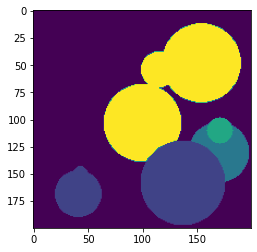

In [17]:
#@title solution for dataloader
import torch
from monai.transforms import LoadImaged, CenterSpatialCropd, AddChanneld, ScaleIntensityd, CastToTyped, ToTensord

trans = Compose(
    [
        LoadImaged(fn_keys, image_only=True),
        AddChanneld(fn_keys),
        CenterSpatialCropd(fn_keys, 200),
        ScaleIntensityd(["img"]),
        CastToTyped(fn_keys, (np.float32, np.int32)),
        ToTensord(fn_keys),
    ]
)

data = trans(filenames[0])
img = data["img"]
seg = data["seg"]

print(img.shape)  # should be (1, 200, 200, 200)
print(img.dtype, seg.dtype)  # should be float32  int32
print(img.min(), img.max())  # should be 0.0 1.0
print(torch.unique(seg))  # should be [0 1 2 3 4 5]

plt.imshow(img[0, img.shape[1] // 2])

# construct dataset and dataloder here and iterate over batches, batch_size of 1 should be used

ds = Dataset(filenames,transform=trans)
loader= DataLoader(ds,batch_size=3)

for batch in loader:
    img = batch["img"]
    seg = batch["seg"]

    print(img.shape)  # should be (3, 1, 200, 200, 200) and (2, 1, 200, 200, 200) - first batch has 3, second has 2.
    print(img.dtype, seg.dtype)  # should be float32  int32
    print(img.min(), img.max())  # should be 0.0 1.0
    print(torch.unique(seg))  # should be [0 1 2 3 4 5]    



## Navigation

- [01 MONAI transform](./01_getting.ipynb)
- [02_end_to_end_pipeline](./02_end_to_end_pipeline.ipynb)
- [03_spleen_segment](./03_spleen_segment.ipynb)
- [04_Auto3DSeg](./04_Auto3DSeg.ipynb)
- [05_Auto3DSeg_hippocampus](./05_Auto3DSeg_hippocampus.ipynb)
- [06_digital_pathology_wsi](./06_digital_pathology_wsi.ipynbb)
- [07_HoverNet_01_inference](./07_HoverNet_01_inference.ipynb)
- [08_HoverNet_02_train](./08_HoverNet_02_train.ipynb)



<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>